In [1]:
import pandas as pd
import numpy as np
from enum import Enum
from sklearn.model_selection import train_test_split

In [2]:
class SPLIT_TYPE(Enum):
    INTRA_USER = 0
    INTER_USER = 1
    

class SPLIT(Enum):
    TRAIN = 0
    TEST = 1


def get_splits(count_df: pd.DataFrame, n:int, test_size=0.2):
    maxsize = int(n * test_size)

    max_threshold = int(maxsize * 1.05)
    min_threshold = int(maxsize * 0.95)

    print(f"{min_threshold=}, {max_threshold=}")
    
    # Allow a 10% tolerance
    def _dp(ix, curr_size, ids, cache):
        
        if ix >= count_df.shape[0]:
            return []

        key = ix

        if key in cache:
            return cache[key]

        if curr_size > max_threshold:
            return []

        if min_threshold <= curr_size <= max_threshold:
            return ids

        # two options - either pick the current id or skip it.
        branch_a = _dp(ix, curr_size+count_df.loc[ix, 'count'], ids+[count_df.loc[ix, 'index']], cache)
        branch_b = _dp(ix+1, curr_size, ids, cache)
        
        curr_max = []
        if branch_a and len(branch_a) > 0:
            curr_max = branch_a
        
        if branch_b and len(branch_b) > len(branch_a):
            curr_max = branch_b
            
        cache[key] = curr_max
        return cache[key]
    
    return _dp(0, 0, ids=list(), cache=dict())


def get_train_test_splits(data: pd.DataFrame, how=SPLIT_TYPE, test_ratio=0.2, shuffle=True):

    n_users = list(data.user_id.unique())
    n = data.shape[0]
    
    if shuffle:
        data = data.sample(data.shape[0]).reset_index(drop=True, inplace=False)

    if how == SPLIT_TYPE.INTER_USER:
        # Make the split, ensuring that a user in one fold is not leaked into the other fold.
        # Basic idea: we want to start with the users with the highest instances and place alternating users in each set.
        counts = data.user_id.value_counts().reset_index(drop=False, inplace=False, name='count')

        # Now, start with the user_id at the top, and keep adding to either split.
        # This can be achieved using a simple DP program.
        test_ids = get_splits(counts, data.shape[0])
        test_data = data.loc[data.user_id.isin(test_ids), :]
        train_index = data.index.difference(test_data.index)
        train_data = data.loc[data.user_id.isin(train_index), :]
        
        return train_data, test_data
    
    elif how == SPLIT_TYPE.INTRA_USER:
        
        # There are certain users with only one observation. What do we do with those?
        # As per the mobilitynet modeling pipeline, we randomly assign them to either the
        # training or test set.
        
        value_counts = data.user_id.value_counts()
        single_count_ids = value_counts[value_counts == 1].index
        
        data_filtered = data.loc[~data.user_id.isin(single_count_ids), :].reset_index(drop=True)
        data_single_counts = data.loc[data.user_id.isin(single_count_ids), :].reset_index(drop=True)
        
        X_tr, X_te = train_test_split(
            data_filtered, test_size=test_ratio, shuffle=shuffle, stratify=data_filtered.user_id
        )
        
        data_single_counts['assigned'] = np.random.choice(['train', 'test'], len(data_single_counts))
        X_tr_merged = pd.concat(
            [X_tr, data_single_counts.loc[data_single_counts.assigned == 'train', :].drop(
                columns=['assigned'], inplace=False
            )],
            ignore_index=True, axis=0
        )
        
        X_te_merged = pd.concat(
            [X_te, data_single_counts.loc[data_single_counts.assigned == 'test', :].drop(
                columns=['assigned'], inplace=False
            )],
            ignore_index=True, axis=0
        )
        
        return X_tr_merged, X_te_merged
    
    raise NotImplementedError("Unknown split type")

## Modeling

In [3]:
import pandas as pd
import biogeme.biogeme as bio
import biogeme.database as db
from biogeme import models
from biogeme.expressions import Beta, DefineVariable
from biogeme.expressions import Variable
import numpy as np

from sklearn.preprocessing import MinMaxScaler

In [4]:
# Read the data.
data = pd.read_csv('../data/preprocessed_data.csv')

In [5]:
# First, we map the user IDs to ints.

USER_MAP = {
    u: i+1 for (i, u) in enumerate(data.user_id.unique())
}

data['user_id'] = data['user_id'].apply(lambda x: USER_MAP[x])

In [6]:
# Now, we split the data (either inter-user or intra-user split)

# 0.98 with this approach.????
# train_data, test_data = get_train_test_splits(data=data, how=SPLIT_TYPE.INTER_USER, shuffle=True)

# 0.965 with this approach.???
train_data, test_data = get_train_test_splits(data=data, how=SPLIT_TYPE.INTRA_USER, shuffle=True)

In [7]:
# Some helper functions that will help ease redundancy in the code.

def drop_columns(df: pd.DataFrame):
    # Drop section_mode_argmax and available_modes.
    return df.drop(columns=[
        'section_mode_argmax', 'available_modes', 'section_duration_argmax', 'section_distance_argmax'
        ], inplace=False)


def scale_time(df: pd.DataFrame):
    # Convert from min -> hrs
    df[[c for c in df.columns if 'tt_' in c]] /= 60.
    return df


def scale_cost(df: pd.DataFrame, split: SPLIT, scaler=None):
    # Scale costs using MinMaxScaler.
    costs = df[[c for c in df.columns if 'cost_' in c]].copy()
    
    if split == SPLIT.TRAIN and scaler is None:
        scaler = MinMaxScaler()
        cost_scaled = pd.DataFrame(
            scaler.fit_transform(costs), 
            columns=['scaled_' + c for c in costs.columns], 
            index=costs.index
        )
    
    elif split == SPLIT.TEST and scaler is not None:
        cost_scaled = pd.DataFrame(
            scaler.transform(costs), 
            columns=['scaled_' + c for c in costs.columns], 
            index=costs.index
        )
        
    else:
        raise NotImplementedError("Unknown split")
    
    df = df.merge(right=cost_scaled, left_index=True, right_index=True)
    
    return df, scaler


def get_database(df: pd.DataFrame, split: SPLIT):
    return db.Database(split.name + '_db', df)


def get_variables():
    USER_ID = Variable('user_id')

    # Availability.
    AV_P_MICRO = Variable('av_p_micro')
    AV_NO_TRIP = Variable('av_no_trip')
    AV_S_CAR = Variable('av_s_car')
    AV_TRANSIT = Variable('av_transit')
    AV_CAR = Variable('av_car')
    AV_S_MICRO = Variable('av_s_micro')
    AV_RIDEHAIL = Variable('av_ridehail')
    AV_WALK = Variable('av_walk')
    AV_UNKNOWN = Variable('av_unknown')

    # Time.
    TT_P_MICRO = Variable('tt_p_micro')
    TT_NO_TRIP = Variable('tt_no_trip')
    TT_S_CAR = Variable('tt_s_car')
    TT_TRANSIT = Variable('tt_transit')
    TT_CAR = Variable('tt_car')
    TT_S_MICRO = Variable('tt_s_micro')
    TT_RIDEHAIL = Variable('tt_ridehail')
    TT_WALK = Variable('tt_walk')
    TT_UNKNOWN = Variable('tt_unknown')

    # Cost.
    CO_P_MICRO = Variable('scaled_cost_p_micro')
    CO_NO_TRIP = Variable('scaled_cost_no_trip')
    CO_S_CAR = Variable('scaled_cost_s_car')
    CO_TRANSIT = Variable('scaled_cost_transit')
    CO_CAR = Variable('scaled_cost_car')
    CO_S_MICRO = Variable('scaled_cost_s_micro')
    CO_RIDEHAIL = Variable('scaled_cost_ridehail')
    CO_WALK = Variable('scaled_cost_walk')
    CO_UNKNOWN = Variable('scaled_cost_unknown')

    # Choice.
    CHOICE = Variable('chosen')
    
    # return the filtered locals() dictionary.
    return {k:v for k,v in locals().items() if not k.startswith('_')}


def exclude_from_db(v_dict: dict, db: db.Database):
    EXCLUDE = (v_dict['CHOICE'] == 2) + (v_dict['CHOICE'] == 9) > 0
    db.remove(EXCLUDE)


def get_params():
    B_TIME = Beta('B_TIME', 0, None, 0, 0)
    B_COST = Beta('B_COST', 0, None, None, 0)

    # Alternative-Specific Constants.
    ASC_P_MICRO = Beta('ASC_P_MICRO', 0, None, None, 0)
    ASC_NO_TRIP = Beta('ASC_NO_TRIP', 0, None, None, 0)
    ASC_S_CAR = Beta('ASC_S_CAR', 0, None, None, 0)
    ASC_TRANSIT = Beta('ASC_TRANSIT', 0, None, None, 0)
    ASC_CAR = Beta('ASC_CAR', 0, None, None, 0)
    ASC_S_MICRO = Beta('ASC_S_MICRO', 0, None, None, 0)
    ASC_RIDEHAIL = Beta('ASC_RIDEHAIL', 0, None, None, 0)
    ASC_WALK = Beta('ASC_WALK', 0, None, None, 0)
    ASC_UNKNOWN = Beta('ASC_UNKNOWN', 0, None, None, 0)
    
    # Return filtered locals dict.
    return {k:v for k,v in locals().items() if not k.startswith('_')}


def get_utility_functions(v: dict):
    V_P_MICRO = (
        v['ASC_P_MICRO'] +
        v['B_TIME'] * v['TT_P_MICRO']
        + v['B_COST'] * v['CO_P_MICRO']
    )

    V_NO_TRIP = (
        v['ASC_NO_TRIP'] +
        v['B_TIME'] * v['TT_NO_TRIP'] +
        v['B_COST'] * v['CO_NO_TRIP']
    )

    V_S_CAR = (
        v['ASC_S_CAR'] +
        v['B_TIME'] * v['TT_S_CAR'] +
        v['B_COST'] * v['CO_S_CAR']
    )

    V_TRANSIT = (
        v['ASC_TRANSIT'] +
        v['B_TIME'] * v['TT_TRANSIT'] +
        v['B_COST'] * v['CO_TRANSIT']
    )

    V_CAR = (
        v['ASC_CAR'] +
        v['B_TIME'] * v['TT_CAR'] +
        v['B_COST'] * v['CO_CAR']
    )

    V_S_MICRO = (
        v['ASC_S_MICRO'] +
        v['B_TIME'] * v['TT_S_MICRO'] +
        v['B_COST'] * v['CO_S_MICRO']
    )

    V_RIDEHAIL = (
        v['ASC_RIDEHAIL'] +
        v['B_TIME'] * v['TT_RIDEHAIL'] +
        v['B_COST'] * v['CO_RIDEHAIL']
    )

    V_WALK = (
        v['ASC_WALK'] +
        v['B_TIME'] * v['TT_WALK']
        + v['B_COST'] * v['CO_WALK']
    )

    V_UNKNOWN = (
        v['ASC_UNKNOWN'] +
        v['B_TIME'] * v['TT_UNKNOWN'] +
        v['B_COST'] * v['CO_UNKNOWN']
    )
    
    # Remember to exclude the input argument.
    return {k:v for k,v in locals().items() if not k.startswith('_') and k != 'v'}


def get_utility_mapping(var: dict):
    # Map alterative to utility functions.
    return {
        1: var['V_P_MICRO'], 
        2: var['V_NO_TRIP'],
        3: var['V_S_CAR'], 
        4: var['V_TRANSIT'],
        5: var['V_CAR'], 
        6: var['V_S_MICRO'],
        7: var['V_RIDEHAIL'], 
        8: var['V_WALK'], 
        9: var['V_UNKNOWN']
    }


def get_availability_mapping(var: dict):
    return {
        1: var['AV_P_MICRO'],
        2: var['AV_NO_TRIP'],
        3: var['AV_S_CAR'],
        4: var['AV_TRANSIT'],
        5: var['AV_CAR'],
        6: var['AV_S_MICRO'],
        7: var['AV_RIDEHAIL'],
        8: var['AV_WALK'],
        9: var['AV_UNKNOWN']
    }

In [8]:
# First, drop columns.

train_data = drop_columns(train_data)

# Next, scale time.
train_data = scale_time(train_data)

# Scale cost.
train_data, scaler = scale_cost(train_data, SPLIT.TRAIN, None)

# get dbs.
train_db = get_database(train_data, SPLIT.TRAIN)

# get vars.
train_vars = get_variables()

# exclude wrong points.
exclude_from_db(train_vars, train_db)

train_params = get_params()
train_vars.update(train_params)

train_V = get_utility_functions(train_vars)
train_vars.update(train_V)

In [9]:
V = get_utility_mapping(train_vars)
av = get_availability_mapping(train_vars)
train_logprob = models.loglogit(V, av, train_vars['CHOICE'])

model = bio.BIOGEME(train_db, train_logprob)
model.modelName = 'linearModelCostsModel-intraUser'

In [10]:
train_results = model.estimate()

/Users/rkulhall/miniconda3/envs/emission/lib/python3.9/site-packages/biogeme_optimization/simple_bounds.py:213: RuntimeWarning: invalid value encountered in scalar divide
  rho = num / denom


In [11]:
print(train_results.short_summary())

Results for model linearModelCostsModel-intraUser
Nbr of parameters:		11
Sample size:			57579
Excluded data:			2118
Final log likelihood:		-3.102707e-05
Akaike Information Criterion:	22.00006
Bayesian Information Criterion:	120.5701



In [12]:
display(train_results.getEstimatedParameters())

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR,42.684494,1.797693e+308,2.374404e-307,1.0
ASC_NO_TRIP,-260.413374,9.457320e+00,-2.753564e+01,0.0
ASC_P_MICRO,33.086180,1.797693e+308,1.840480e-307,1.0
ASC_RIDEHAIL,34.002320,1.797693e+308,1.891442e-307,1.0
ASC_S_CAR,40.697532,1.797693e+308,2.263875e-307,1.0
ASC_S_MICRO,18.971189,1.797693e+308,1.055307e-307,1.0
ASC_TRANSIT,35.842813,1.797693e+308,1.993823e-307,1.0
ASC_UNKNOWN,0.000000,1.845808e-13,0.000000e+00,1.0
ASC_WALK,55.128845,1.797693e+308,3.066644e-307,1.0
B_COST,-2272.771003,1.214323e+02,-1.871636e+01,0.0


In [13]:
def get_utility_df(results, data):

    def compute_utilities(betas, row: pd.Series):
        data = row.to_dict()

        utility_p_micro = betas['ASC_P_MICRO'] + (betas['B_TIME'] * data['tt_p_micro'])
        utility_no_trip = betas['ASC_NO_TRIP'] + (betas['B_TIME'] * data['tt_no_trip']) + (betas['B_COST'] * data['scaled_cost_no_trip'])
        utility_s_car = betas['ASC_S_CAR'] + (betas['B_COST'] * data['scaled_cost_s_car']) + (betas['B_TIME'] * data['tt_s_car'])
        utility_transit = betas['ASC_TRANSIT'] + (betas['B_COST'] * data['scaled_cost_transit']) + (betas['B_TIME'] * data['tt_transit'])
        utility_car = betas['ASC_CAR'] + (betas['B_COST'] * data['scaled_cost_car'] + (betas['B_TIME'] * data['tt_car']))
        utility_s_micro = betas['ASC_S_MICRO'] + (betas['B_COST'] * data['scaled_cost_s_micro']) + (betas['B_TIME'] * data['tt_s_micro'])
        utility_ridehail = betas['ASC_RIDEHAIL'] + (betas['B_COST'] * data['scaled_cost_ridehail']) + (betas['B_TIME'] * data['tt_ridehail'])
        utility_walk = betas['ASC_WALK'] + (betas['B_TIME'] * data['tt_walk'])
        utility_unknown = betas['ASC_UNKNOWN'] + (betas['B_TIME'] * data['tt_unknown']) + (betas['B_COST'] * data['scaled_cost_unknown'])

        return {
            'utility_p_micro': utility_p_micro, 'utility_no_trip': utility_no_trip,
            'utility_s_car': utility_s_car, 'utility_transit': utility_transit,
            'utility_car': utility_car, 'utility_s_micro': utility_s_micro,
            'utility_ridehail': utility_ridehail, 'utility_walk': utility_walk, 
            'utility_unknown': utility_unknown, 
        }
    
    betas = results.getBetaValues()

    u_data = data.apply(lambda x: compute_utilities(betas, x), axis=1).tolist()
    return pd.DataFrame(u_data)

In [14]:
test_data = drop_columns(test_data)

# Next, scale time.
test_data = scale_time(test_data)

# Scale cost.
test_data, _ = scale_cost(test_data, SPLIT.TEST, scaler)

# get dbs.
test_db = get_database(test_data, SPLIT.TEST)

In [15]:
test_utilities = get_utility_df(train_results, test_data)

In [16]:
display(test_utilities.head())

,utility_p_micro,utility_no_trip,utility_s_car,utility_transit,utility_car,utility_s_micro,utility_ridehail,utility_walk,utility_unknown
0,-18.241189,-260.413374,17.827530,-13.045518,-6.745978,-45.912237,-15.428152,-157.474693,-47.457612
1,15.548732,-260.413374,11.626470,13.067221,13.613432,-0.558474,4.931258,53.723791,-26.574742
2,14.974088,-260.413374,-31.381507,-42.094303,-29.394545,-96.365456,-38.076719,-325.992645,-70.688496
3,-21.417490,-260.413374,15.997066,-15.500152,-8.659791,-50.175555,-17.341965,-171.714529,-49.420631
4,-54.925702,-260.413374,-3.313322,-41.395187,-28.849463,-95.151201,-37.531637,-321.936932,-70.129400


In [17]:
u_np = test_utilities.values
choice_df = np.exp(u_np)/np.sum(np.exp(u_np), axis=1, keepdims=True)

choice_df = pd.DataFrame(choice_df, columns=test_utilities.columns)
display(choice_df.head())

,utility_p_micro,utility_no_trip,utility_s_car,utility_transit,utility_car,utility_s_micro,utility_ridehail,utility_walk,utility_unknown
0,2.165480e-16,1.450476e-121,1.000000e+00,3.908458e-14,2.127458e-11,2.080515e-28,3.607785e-15,7.365664e-77,4.436322e-29
1,2.635013e-17,3.732181e-137,5.216339e-19,2.203312e-18,3.804454e-18,2.663865e-24,6.451670e-22,1.000000e+00,1.339030e-35
2,1.000000e+00,2.516197e-120,7.379397e-21,1.642527e-25,5.382046e-20,4.424358e-49,9.126982e-24,8.318201e-149,6.269204e-38
3,5.637221e-17,9.046302e-121,1.000000e+00,2.093784e-14,1.957325e-11,1.826401e-29,3.319272e-15,3.005315e-82,3.885574e-29
4,3.846168e-23,2.202248e-112,1.000000e+00,2.892386e-17,8.124469e-12,1.304116e-40,1.377764e-15,4.202665e-139,9.597242e-30


In [18]:
from sklearn.metrics import f1_score

y_pred = np.argmax(choice_df.values, axis=1) + 1

print(np.unique(y_pred))

[1 2 3 4 5 8 9]


In [19]:
y_true = test_data.chosen
score = f1_score(y_true, y_pred, average='weighted')

print(score)

0.9692918926841162


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

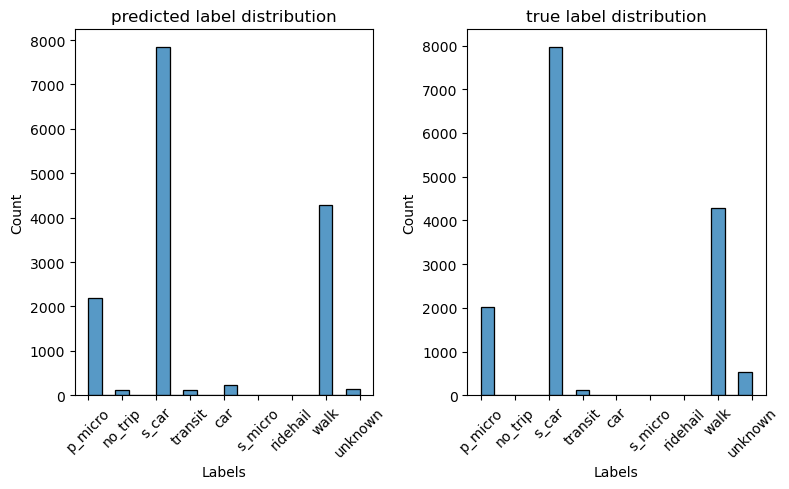

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

sns.histplot(y_pred, ax=ax[0])
sns.histplot(y_true, ax=ax[1])

labels = [
    'p_micro', 
    'no_trip',
    's_car', 
    'transit',
    'car', 
    's_micro',
    'ridehail', 
    'walk', 
    'unknown'
]

ax[0].set(
    title='predicted label distribution',
    xlabel='Labels',
    xticks=range(1, 10),
    xticklabels=labels
)

ax[1].set(
    title='true label distribution',
    xlabel='Labels',
    xticks=range(1, 10),
    xticklabels=labels
)

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[1].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()